<a href="https://colab.research.google.com/github/ISKaya036/-Build-WSA-https-github.com-LSPosed-MagiskOnWSA-actions-workflows-magisk.yml-badge.svg-branch-m/blob/main/BUSC7028_Session5_Seminar_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BUSC7028_Session5_Seminar

**Format:** Interactive seminar with guided coding, case studies, and discussion.  
**Tools:** Python, scikit-learn, matplotlib (no seaborn).  
**Goal:** Build models that generalize using rigorous validation, tuning, and appropriate metrics.




In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, average_precision_score,
                             mean_absolute_error, mean_squared_error, r2_score)

from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', 120)

---
# Case Study 1 — Classification: Customer Churn

**Objective:** Predict customer churn and optimize model performance via cross-validation and hyperparameter tuning.

**You will practice:**
- Data preprocessing (impute, encode, scale)
- Train/test vs **Stratified k-Fold CV**
- **GridSearchCV** (and optionally RandomizedSearchCV)
- Metrics: Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC
- **Threshold tuning** for business trade-offs


# 1.1 Read customer_churn_case.csv

In [ ]:
dfc = pd.read_csv('customer_churn_case.csv')
dfc.head()

,customer_id,tenure_months,monthly_fee,contract_type,payment_method,support_tickets_3m,addon_backup,addon_premium,region,weekly_logins,session_minutes,integrations,days_since_marketing,churn
0,C200000,6,52.98,month_to_month,paypal,2,yes,no,South,7.46,17.20,1,82,0
1,C200001,47,34.97,month_to_month,debit_card,2,no,no,East,8.93,22.61,4,36,0
2,C200002,40,42.36,one_year,credit_card,1,no,no,East,4.63,16.21,2,35,0
3,C200003,27,9.08,month_to_month,paypal,0,no,no,North,6.96,8.04,0,73,0
4,C200004,26,24.12,month_to_month,credit_card,2,no,no,North,6.71,21.20,2,33,1


## 1.2 Quick EDA & Split

In [ ]:
dfc.describe(include='all')[:12]

,customer_id,tenure_months,monthly_fee,contract_type,payment_method,support_tickets_3m,addon_backup,addon_premium,region,weekly_logins,session_minutes,integrations,days_since_marketing,churn
count,1200,1200.00000,1168.000000,1200,1200,1200.000000,1200,1200,1200,1200.000000,1174.000000,1200.000000,1200.000000,1200.000000
unique,1200,NaN,NaN,3,4,NaN,2,2,4,NaN,NaN,NaN,NaN,NaN
top,C201183,NaN,NaN,month_to_month,credit_card,NaN,no,no,East,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,766,321,NaN,825,948,313,NaN,NaN,NaN,NaN,NaN
mean,NaN,30.75500,37.316926,NaN,NaN,0.936667,NaN,NaN,NaN,5.709850,17.547036,2.583333,44.110833,0.145833
std,NaN,17.25881,12.233321,NaN,NaN,0.946080,NaN,NaN,NaN,2.204968,6.491749,1.700137,25.664940,0.353086
min,NaN,1.00000,5.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,1.000000,0.000000,0.000000,0.000000
25%,NaN,16.00000,29.427500,NaN,NaN,0.000000,NaN,NaN,NaN,4.247500,13.140000,1.000000,22.000000,0.000000
50%,NaN,31.00000,37.730000,NaN,NaN,1.000000,NaN,NaN,NaN,5.680000,17.440000,3.000000,44.000000,0.000000
75%,NaN,46.00000,45.192500,NaN,NaN,1.000000,NaN,NaN,NaN,7.150000,22.030000,4.000000,65.000000,0.000000


In [ ]:
# Split
X = dfc.drop(columns=['churn', 'customer_id'])
y = dfc['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((960, 12),
 (240, 12),
 np.float64(0.14583333333333334),
 np.float64(0.14583333333333334))

## 1.3 Preprocessing Pipeline (Impute, Encode, Scale)

In [ ]:
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

num_cols, cat_cols

(['tenure_months',
  'monthly_fee',
  'support_tickets_3m',
  'weekly_logins',
  'session_minutes',
  'integrations',
  'days_since_marketing'],
 ['contract_type',
  'payment_method',
  'addon_backup',
  'addon_premium',
  'region'])

## 1.4 Baseline vs Cross-Validation

In [ ]:
dummy = Pipeline([('prep', preprocess), ('model', DummyClassifier(strategy='most_frequent'))])
dummy.fit(X_train, y_train)
print('Dummy test accuracy:', dummy.score(X_test, y_test))

rf = Pipeline([('prep', preprocess), ('model', RandomForestClassifier(random_state=RANDOM_STATE))])
svm = Pipeline([('prep', preprocess), ('model', SVC(probability=True, random_state=RANDOM_STATE))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, est in [('RandomForest', rf), ('SVM', svm)]:
    scores = cross_val_score(est, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name} CV accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Dummy test accuracy: 0.8541666666666666
RandomForest CV accuracy: 0.854 ± 0.000
SVM CV accuracy: 0.854 ± 0.000


## 1.5 Hyperparameter Tuning (GridSearchCV)

In [ ]:
# Grid for Random Forest
rf_grid = {
    'model__n_estimators': [200, 400],
    'model__max_depth': [None, 8, 14],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(rf, rf_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

print('Best RF params:', grid_rf.best_params_)
print('Best RF CV ROC-AUC:', grid_rf.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF params: {'model__max_depth': 8, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Best RF CV ROC-AUC: 0.568336236933798


### Evaluate Tuned RF on Test Set (Solution)

Test Accuracy: 0.8541666666666666
Test Precision: 0.0
Test Recall: 0.0
Test F1: 0.0
Test ROC-AUC: 0.5891289198606271


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


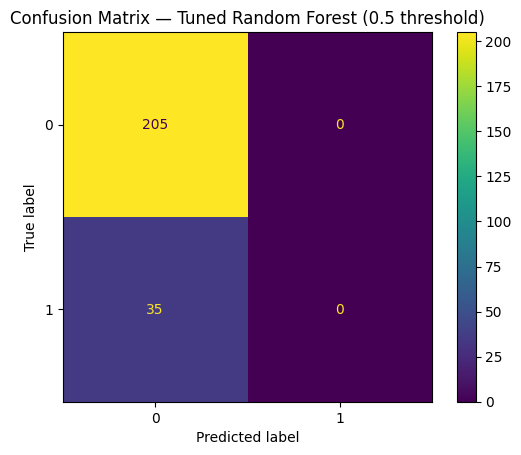

In [ ]:
best_rf = grid_rf.best_estimator_
y_proba = best_rf.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Test Precision:', precision_score(y_test, y_pred))
print('Test Recall:', recall_score(y_test, y_pred))
print('Test F1:', f1_score(y_test, y_pred))
print('Test ROC-AUC:', roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title('Confusion Matrix — Tuned Random Forest (0.5 threshold)')
plt.show()

### ROC & PR Curves

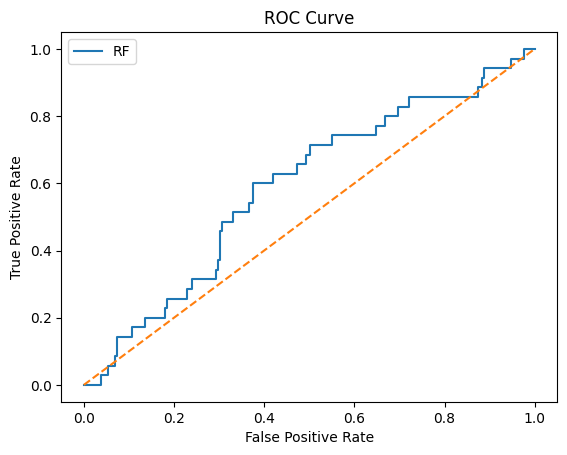

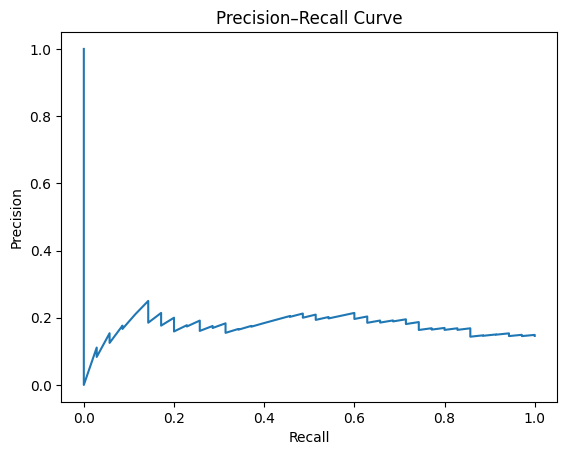

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label='RF')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.show()

### Threshold Tuning Table

In [ ]:
ths = np.linspace(0.05, 0.95, 19)
rows = []
for t in ths:
    pred = (y_proba >= t).astype(int)
    rows.append({
        'threshold': t,
        'accuracy': accuracy_score(y_test, pred),
        'precision': precision_score(y_test, pred, zero_division=0),
        'recall': recall_score(y_test, pred, zero_division=0),
        'f1': f1_score(y_test, pred, zero_division=0)
    })
thr_table = pd.DataFrame(rows).round(3)
thr_table.head(10)

,threshold,accuracy,precision,recall,f1
0,0.05,0.158,0.148,1.000,0.257
1,0.10,0.388,0.167,0.800,0.276
2,0.15,0.600,0.204,0.600,0.304
3,0.20,0.733,0.191,0.257,0.220
4,0.25,0.804,0.167,0.086,0.113
5,0.30,0.833,0.000,0.000,0.000
6,0.35,0.846,0.000,0.000,0.000
7,0.40,0.854,0.000,0.000,0.000
8,0.45,0.854,0.000,0.000,0.000
9,0.50,0.854,0.000,0.000,0.000


---
# Case Study 2 — Regression: House Prices

**Objective:** Predict house prices and choose a model via **regularization** and **cross-validation**.

**You will practice:**
- Synthesizing a realistic regression dataset
- Baseline vs Regularized models (Ridge/Lasso/Elastic Net)
- **K-Fold CV** with multiple metrics
- Coefficient shrinkage intuition and model comparison


## 2.1 Read house_price_case.csv

In [ ]:
dfr = pd.read_csv('house_prices_case.csv')

**Saved dataset:** `house_prices_case.csv`

## 2.2 Split & Preprocess

In [ ]:
Xr = dfr.drop(columns=['price'])
yr = dfr['price']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=RANDOM_STATE)

num_cols_r = Xr.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols_r = Xr.select_dtypes(include=['object','category','bool']).columns.tolist()

numeric_transformer_r = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer_r = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocess_r = ColumnTransformer([
    ('num', numeric_transformer_r, num_cols_r),
    ('cat', categorical_transformer_r, cat_cols_r)
])

num_cols_r, cat_cols_r, Xr_train.shape, Xr_test.shape

(['sqft',
  'bedrooms',
  'bathrooms',
  'age_years',
  'distance_city_km',
  'has_garage'],
 ['neighbourhood'],
 (960, 7),
 (240, 7))

## 2.3 Baseline vs Regularized Models with CV

In [ ]:
# Pipelines
ridge = Pipeline([('prep', preprocess_r), ('model', Ridge())])
lasso = Pipeline([('prep', preprocess_r), ('model', Lasso(max_iter=10000))])
enet  = Pipeline([('prep', preprocess_r), ('model', ElasticNet(max_iter=10000))])
rfreg = Pipeline([('prep', preprocess_r), ('model', RandomForestRegressor(random_state=RANDOM_STATE))])

# CV setup
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {'RMSE': 'neg_root_mean_squared_error', 'MAE':'neg_mean_absolute_error', 'R2':'r2'}

def summarize_cv(pipe, X, y, name):
    res = cross_validate(pipe, X, y, cv=kfold, scoring=scoring, return_train_score=False, n_jobs=-1)
    out = {
        'Model': name,
        'RMSE (cv)': -np.mean(res['test_RMSE']),
        'MAE (cv)': -np.mean(res['test_MAE']),
        'R2 (cv)': np.mean(res['test_R2'])
    }
    return out

summary = pd.DataFrame([
    summarize_cv(ridge, Xr_train, yr_train, 'Ridge'),
    summarize_cv(lasso, Xr_train, yr_train, 'Lasso'),
    summarize_cv(enet,  Xr_train, yr_train, 'ElasticNet'),
    summarize_cv(rfreg, Xr_train, yr_train, 'RandomForestRegressor')
]).round(2)
summary

,Model,RMSE (cv),MAE (cv),R2 (cv)
0,Ridge,29737.91,23801.20,0.84
1,Lasso,29737.34,23799.72,0.84
2,ElasticNet,39609.99,31890.20,0.72
3,RandomForestRegressor,35289.94,28199.18,0.77


## 2.4 Hyperparameter Tuning

In [ ]:
# Ridge/Lasso/ENet grids (small for class time)
ridge_grid = {'model__alpha': np.logspace(-2, 3, 8)}
lasso_grid = {'model__alpha': np.logspace(-2, 2, 8)}
enet_grid  = {'model__alpha': np.logspace(-2, 2, 6), 'model__l1_ratio': [0.2, 0.5, 0.8]}

ridge_gs = GridSearchCV(ridge, ridge_grid, scoring='neg_root_mean_squared_error', cv=kfold, n_jobs=-1)
lasso_gs = GridSearchCV(lasso, lasso_grid, scoring='neg_root_mean_squared_error', cv=kfold, n_jobs=-1)
enet_gs  = GridSearchCV(enet,  enet_grid,  scoring='neg_root_mean_squared_error', cv=kfold, n_jobs=-1)

for gs, name in [(ridge_gs,'Ridge'), (lasso_gs,'Lasso'), (enet_gs,'ElasticNet')]:
    gs.fit(Xr_train, yr_train)
    print(f"{name} best params:", gs.best_params_, "CV RMSE:", -gs.best_score_)

Ridge best params: {'model__alpha': np.float64(0.01)} CV RMSE: 29737.31552054904
Lasso best params: {'model__alpha': np.float64(0.01)} CV RMSE: 29737.313744153922
ElasticNet best params: {'model__alpha': np.float64(0.01), 'model__l1_ratio': 0.8} CV RMSE: 29738.55553496266


### 2.5 Evaluate Best Model on Test

Best linear regularized model: ElasticNet
Test RMSE: 30241.46 MAE: 23700.99 R2: 0.852


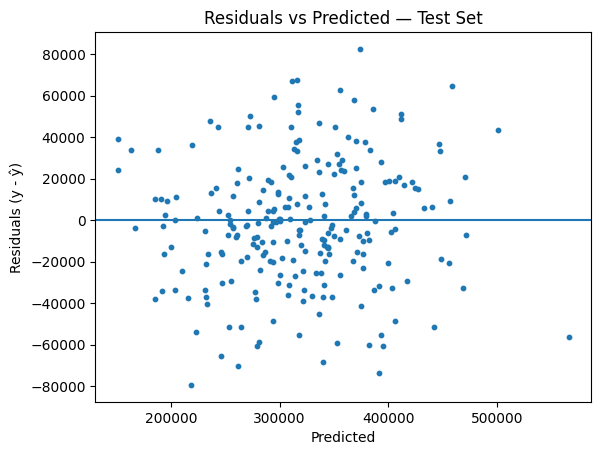

In [ ]:
# Choose the best by CV RMSE among linear regularized models
candidates = [('Ridge', ridge_gs), ('Lasso', lasso_gs), ('ElasticNet', enet_gs)]
best_name, best_gs = sorted(candidates, key=lambda kv: -kv[1].best_score_)[-1]  # lower RMSE is better

best_model = best_gs.best_estimator_
best_model.fit(Xr_train, yr_train)
pred = best_model.predict(Xr_test)

rmse = np.sqrt(mean_squared_error(yr_test, pred))
mae  = mean_absolute_error(yr_test, pred)
r2   = r2_score(yr_test, pred)

print('Best linear regularized model:', best_name)
print('Test RMSE:', round(rmse,2), 'MAE:', round(mae,2), 'R2:', round(r2,3))

# Residual plot
resid = yr_test - pred
plt.figure()
plt.scatter(pred, resid, s=10)
plt.axhline(0)
plt.xlabel('Predicted'); plt.ylabel('Residuals (y - ŷ)')
plt.title('Residuals vs Predicted — Test Set')
plt.show()

**Student Task (5–10 min):**
- Compare the tuned linear model vs **RandomForestRegressor** on test set.  
- Which has lower RMSE? Discuss interpretability vs performance.  
- Bonus: Add **PolynomialFeatures** before Ridge (in numeric pipeline) and see if RMSE improves (risk of overfitting!).


---
# Reflection, Comparison & Wrap-up

## Key Takeaways
- **Cross-validation** gives a more **reliable performance estimate** than a single split.  
- **Hyperparameter tuning** (Grid/Random search) often delivers **significant gains**.  
- Choose **metrics** aligned with your business objective (e.g., Recall for safety, Precision for cost control, RMSE for squared loss).  
- **Regularization** controls model complexity to combat overfitting.

## Quick Quiz (answers in instructor notes)
1. Why can a single 80/20 split be misleading compared to 5-fold CV?  
2. When would you pick PR-AUC over ROC-AUC?  
3. In Lasso vs Ridge, which drives coefficients exactly to zero and why might that be useful?

## Instructor Notes (solutions)
1. Single split has higher variance; CV averages across folds for stability.  
2. When **positives are rare** (class imbalance) and you care about ranking positives accurately.  
3. **Lasso (L1)**; it performs feature selection → simpler, more interpretable models.
